In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
patients_df = pd.read_csv('data/adhd_data.csv')
patients_df[::]

In [ ]:
# Get all patients whose notes contain the word "hallucinations"
hallucinations_df = patients_df[patients_df["hallucinations"] == True]
ocd_df = patients_df[patients_df["ocd"] == True]
adhd_only_df = patients_df[patients_df["hallucinations"] == False]
#adhd_only_df = adhd_only_df[adhd_only_df["ocd"] == False]

print(f"Hallucinations: {len(hallucinations_df)}")
print(f"OCD: {len(ocd_df)}")
print(f"ADHD Only: {len(adhd_only_df)}")

data = {"hallucinations": len(hallucinations_df), "ocd": len(ocd_df), "adhd_only": len(adhd_only_df)}

# Convert dictionary to a DataFrame for plotting
df_plot = pd.DataFrame(list(data.items()), columns=["Condition", "Count"])

# Plot the bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Condition", y="Count", data=df_plot)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Count of Patients with Hallucinations, OCD, and ADHD Only")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.show()

In [ ]:
patients_df[::]

In [ ]:
h_male, h_female = [hallucinations_df[hallucinations_df["gender"] == g] for g in [True, False]]
o_male, o_female = [ocd_df[ocd_df["gender"] == g] for g in [True, False]]
a_male, a_female = [adhd_only_df[adhd_only_df["gender"] == g] for g in [True, False]]

# Data for plotting
data_gender_split = {
    "Condition": ["Hallucinations", "Hallucinations", "OCD", "OCD", "ADHD Only", "ADHD Only"],
    "Gender": ["Male", "Female", "Male", "Female", "Male", "Female"],
    "Count": [len(h_male), len(h_female), len(o_male), len(o_female), len(a_male), len(a_female)]
}

print(f"{len(h_male)} | {len(h_female)} | {len(o_male)} | {len(o_female)} | {len(a_male)} | {len(a_female)}")

# Convert to DataFrame
df_plot = pd.DataFrame(data_gender_split)

# Create a bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Condition", y="Count", hue="Gender", data=df_plot, palette="pastel")

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Titles and labels
plt.title("Count of Patients by Condition and Gender")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.show()


In [ ]:
# TODO: Do some DL/ML on this data
"""
Take the existing data
Fit it into a model (figure out which model would work best)
    Find one where a kmean grouping can find the most common factors that relate these issues.
"""

#Preprocess data to numbers
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

data_encoded = pd.get_dummies(patients_df, columns=["gender", "drug"])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_encoded)

kmeans = KMeans(n_clusters=3, random_state=30, n_init=10)
data_encoded['cluster'] = kmeans.fit_predict(df_scaled)


print(data_encoded.groupby('cluster').mean())
print(data_encoded.groupby('cluster').size())

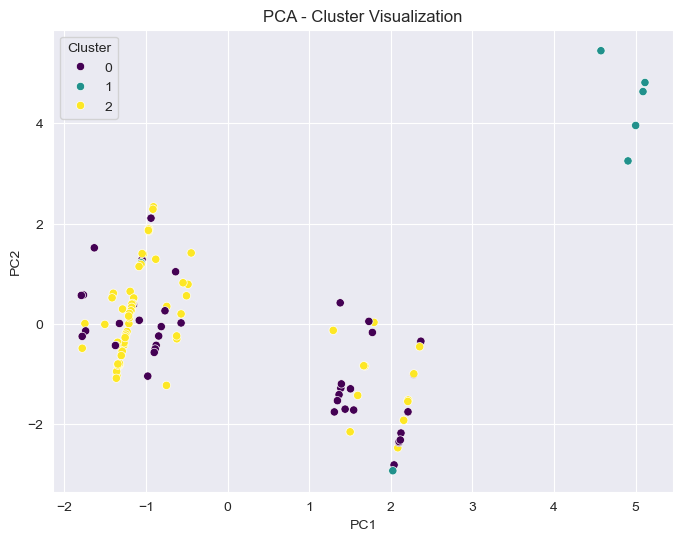

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 principal components
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = kmeans.labels_

# Scatter plot of clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="viridis")
plt.title("PCA - Cluster Visualization")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Prepare data
df_tensor = torch.tensor(df_scaled, dtype=torch.float32)

# Initialize and train the autoencoder
model = Autoencoder(input_dim=df_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    output = model(df_tensor)
    loss = criterion(output, df_tensor)
    loss.backward()
    optimizer.step()

# Extract encoded features
encoded_features = model.encoder(df_tensor).detach().numpy()

# Cluster with K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data_encoded['cluster'] = kmeans.fit_predict(encoded_features)

#print(patients_df.groupby("cluster").mean())
print(data_encoded.groupby("cluster").size())

In [ ]:
data_encoded[::]

a = data_encoded.groupby("cluster")
b = a.size()
c = a.mean()

print(a.describe())

In [ ]:
feature_columns = ["subject_id","gender","drug","hallucinations","ocd"]


pca_components = pd.DataFrame(pca.components_, columns=feature_columns, index=[f"PC{i+1}" for i in range(pca.n_components_)])
pca_components.T.sort_values(by="PC1", ascending=False).head(10)  # Top 10 features affecting PC1

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(data_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()